In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv("data/data_bpi2013/trace_activities.csv")

In [42]:
# data = data.drop(columns=["index", "EVENTID"])
data["start"] = pd.to_datetime(data["start"])
data["end"] = pd.to_datetime(data["end"])

attributes = [
    attr
    for attr in data.select_dtypes(include=["object", "bool", "number"]).columns
    if attr not in ["traceId", "activity", "start", "end"]
]


def is_trace_level(attribute):
    return data.groupby("traceId")[attribute].nunique().max() == 1


selected_attributes = [attr for attr in attributes if is_trace_level(attr)]

In [43]:
data["activity_duration"] = (data["end"] - data["start"]).dt.total_seconds().astype(int)

data["activity_durations"] = data.groupby("traceId")["activity_duration"].transform(
    lambda x: [x.tolist()] * len(x)
)

data["transition_duration"] = (
    (data.groupby("traceId")["start"].shift(-1) - data["end"])
    .dt.total_seconds()
    .fillna(0)
    .astype(int)
)


data["transition_durations"] = data.groupby("traceId")["transition_duration"].transform(
    lambda x: [x.tolist()] * len(x)
)

trace_total_duration = (
    data.groupby("traceId")
    .apply(lambda x: (x["end"].max() - x["start"].min()).total_seconds())
    .reset_index(name="trace_total_duration")
)


data = pd.merge(data, trace_total_duration, on="traceId")

In [44]:
activities = data["activity"].unique().tolist()
activity_to_index = {activity: i for i, activity in enumerate(activities)}
data["activity"] = data["activity"].map(activity_to_index)


def decode_activities(indices, index_to_activity):
    return [index_to_activity[index] for index in indices]


data["trace_activity_list"] = data.groupby("traceId")["activity"].transform(
    lambda x: [x.tolist()] * len(x)
)

In [45]:
data = data.drop_duplicates(subset="traceId")[
    [
        "traceId",
        "trace_activity_list",
        "activity_durations",
        "transition_durations",
        "trace_total_duration",
    ]
    + selected_attributes
]

In [46]:
def assert_duration_consistency(row):
    activity_sum = sum(row["activity_durations"])
    transition_sum = sum(row["transition_durations"])
    total_duration = row["trace_total_duration"]
    assert (
        activity_sum + transition_sum == total_duration
    ), f"Inconsistency found in trace {row['traceId']}: {activity_sum} (activities) + {transition_sum} (transitions) != {total_duration} (total)"


data.apply(assert_duration_consistency, axis=1)
print("All durations are consistent.")

All durations are consistent.


In [47]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in (
    data[selected_attributes].select_dtypes(include=["object", "category"]).columns
):
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

for col in data[selected_attributes].select_dtypes(include=["bool"]).columns:
    data[col] = data[col].astype(int)

In [48]:
from sklearn.ensemble import RandomForestRegressor

X = data[selected_attributes]
y = data["trace_total_duration"]

model = RandomForestRegressor(random_state=42)
model.fit(X, y)

feature_importances = pd.DataFrame(
    {"feature": X.columns, "importance": model.feature_importances_}
).sort_values(by="importance", ascending=False)

feature_importances["cumulative_importance"] = feature_importances[
    "importance"
].cumsum()

important_attributes = feature_importances[
    feature_importances["cumulative_importance"] <= 0.95
]["feature"].tolist()

attributes_to_exclude = list(set(selected_attributes) - set(important_attributes))
data = data.drop(columns=attributes_to_exclude)

In [49]:
data

,traceId,trace_activity_list,activity_durations,transition_durations,trace_total_duration,Product,VariantId
0,1-687085471,"[0, 0, 1, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[60, 180, 79320, 14160, 300, 165420, 187140, 0...",7114500.0,28,671
23,1-726532802,"[0, 0, 1, 6, 5]","[0, 0, 0, 0, 0]","[60, 420, 1211940, 0, 0]",1212420.0,307,1433
28,1-730129661,"[0, 0, 3, 0, 3, 0, 5, 6]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 60, 553740, 60, 155700, 60, 653880, 0]",1363500.0,200,1088
36,1-733073371,"[3, 3, 0, 0, 5, 6]","[0, 0, 0, 0, 0, 0]","[720, 0, 604500, 2820, 638700, 0]",1246740.0,307,1001
42,1-733456610,"[0, 0, 7, 0, 5, 6]","[0, 0, 0, 0, 0, 0]","[60, 540, 930540, 240, 640320, 0]",1571700.0,349,1255
...,...,...,...,...,...,...,...
65507,1-740680403,"[0, 0, 3, 2, 0, 0, 5, 6]","[0, 0, 0, 0, 0, 0, 0, 0]","[120, 2580, 60, 0, 180, 2580, 631320, 0]",636840.0,527,446
65515,1-740681032,"[0, 0, 8]","[0, 0, 0]","[60, 660, 0]",720.0,307,0
65518,1-740683221,"[3, 0, 1, 5, 6]","[0, 0, 0, 0, 0]","[2760, 120, 2520, 18300, 0]",23700.0,213,1144
65523,1-740824347,"[0, 0, 5, 6]","[0, 0, 0, 0]","[60, 60, 12780, 0]",12900.0,110,1


In [50]:
import numpy as np

np.random.seed(42)


def truncate_sequence_random(seq):
    if len(seq) > 1:
        trunc_point = np.random.randint(1, len(seq))
        truncated = seq[:trunc_point]
        remaining = seq[trunc_point:]
    else:
        truncated = seq
        remaining = []
        trunc_point = len(seq)
    return truncated, remaining, trunc_point

def truncate_sequence_gaussian(seq):
    if len(seq) > 1:
        mean = len(seq) / 2
        std_dev = len(seq) / 4

        trunc_point = int(np.clip(np.random.normal(mean, std_dev), 1, len(seq)-1))
        truncated = seq[:trunc_point]
        remaining = seq[trunc_point:]
    else:
        truncated = seq
        remaining = []
        trunc_point = len(seq)
    
    return truncated, remaining, trunc_point


def truncate_list(lst, trunc_points, offset=0):
    truncated = [
        item[: truncation_point - offset]
        for item, truncation_point in zip(lst, trunc_points)
    ]
    remaining = [
        item[truncation_point - offset :]
        for item, truncation_point in zip(lst, trunc_points)
    ]
    return truncated, remaining


data[["truncated_tokenized", "remaining_tokenized", "trunc_point"]] = (
    data["trace_activity_list"].apply(truncate_sequence_gaussian).apply(pd.Series)
)

data["truncated_durations"], data["remaining_durations"] = truncate_list(
    data["activity_durations"], data["trunc_point"]
)
data["truncated_transitions"], data["remaining_transitions"] = truncate_list(
    data["transition_durations"], data["trunc_point"], offset=1
)

data["truncated_total_duration"] = data["truncated_durations"].apply(sum) + data[
    "truncated_transitions"
].apply(sum)
data["remaining_total_duration"] = data["remaining_durations"].apply(sum) + data[
    "remaining_transitions"
].apply(sum)

assert all(
    data["truncated_total_duration"] + data["remaining_total_duration"]
    == data["trace_total_duration"]
)

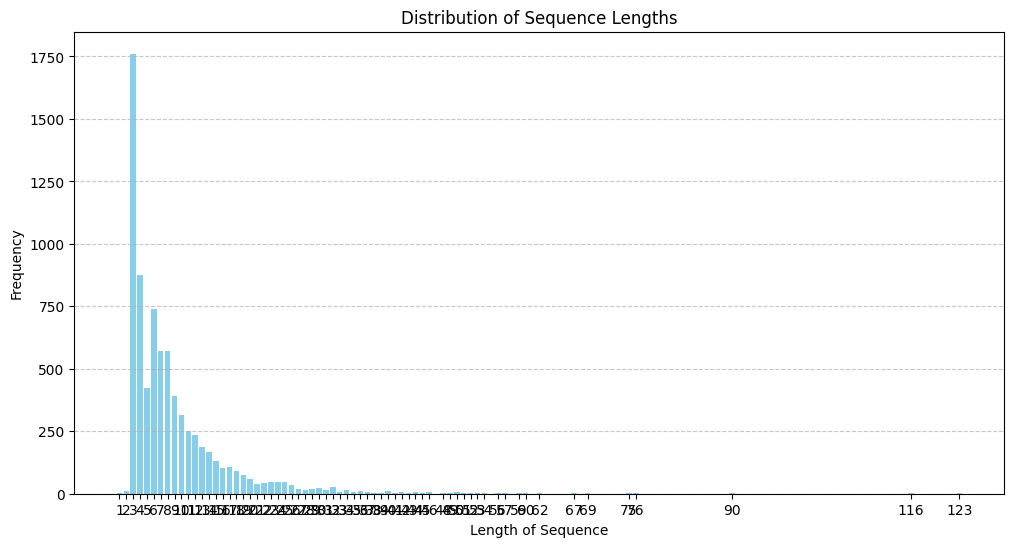

In [51]:
data['sequence_length'] = data['trace_activity_list'].apply(len)

# Aggregate data by sequence length and count frequencies
length_counts = data['sequence_length'].value_counts().sort_index()

# Create a DataFrame for easier plotting
length_distribution = pd.DataFrame(length_counts).reset_index()
length_distribution.columns = ['Length', 'Frequency']

plt.figure(figsize=(12, 6))
plt.bar(length_distribution['Length'], length_distribution['Frequency'], color='skyblue')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Length of Sequence')
plt.ylabel('Frequency')
plt.xticks(length_distribution['Length'])  # Ensure all length ticks are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

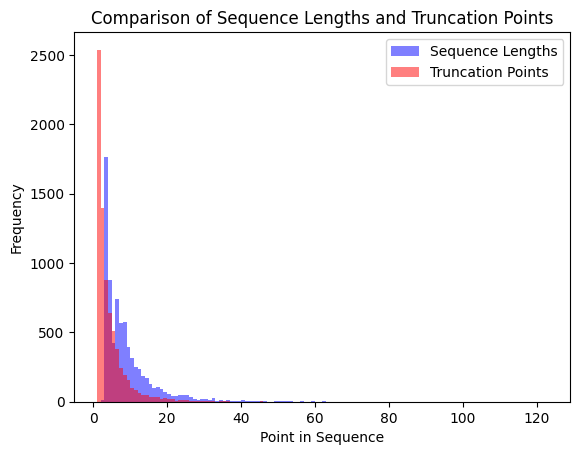

In [52]:
# Calculate the lengths of each trace_activity_list
data["sequence_length"] = data["trace_activity_list"].apply(len)

fig, ax = plt.subplots()
ax.hist(
    data["sequence_length"],
    bins=range(1, data["sequence_length"].max() + 1),
    color="blue",
    alpha=0.5,
    label="Sequence Lengths",
)
ax.hist(
    data["trunc_point"],
    bins=range(1, data["sequence_length"].max() + 1),
    color="red",
    alpha=0.5,
    label="Truncation Points",
)
ax.set_title("Comparison of Sequence Lengths and Truncation Points")
ax.set_xlabel("Point in Sequence")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()